In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joblib

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTEN

import warnings
warnings.filterwarnings("ignore")

In [3]:
from utils import clean_text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/mr-
[nltk_data]    |     francis/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/mr-
[nltk_data]    |     francis/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/mr-francis/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/mr-francis/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to /home/mr-
[nltk_data]    |     francis/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | D

Loading tweets data set

In [4]:
twitter = pd.read_csv("tweets.csv")
twitter.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


checking for the shape of the data 

In [5]:
twitter_ = twitter.drop(columns=['selected_text', "textID"])
twitter_

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [6]:
twitter_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


### checking for missing value

In [7]:
twitter_.isnull().sum()

text         1
sentiment    0
dtype: int64

In [8]:
tweet = twitter_.dropna()
tweet

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


performing feature engineering removing unnecessary columns

In [9]:
tweet['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Getting the length of each sentence

In [10]:
tweet['length'] = tweet['text'].apply(lambda X: len(str(X).split(' ')))
tweet

,text,sentiment,length
0,"I`d have responded, if I were going",neutral,8
1,Sooo SAD I will miss you here in San Diego!!!,negative,11
2,my boss is bullying me...,negative,5
3,what interview! leave me alone,negative,6
4,"Sons of ****, why couldn`t they put them on t...",negative,15
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18
27477,I`ve wondered about rake to. The client has ...,negative,26
27478,Yay good for both of you. Enjoy the break - y...,positive,24
27479,But it was worth it ****.,positive,8


In [11]:
# tweet['sentiment_review'] = tweet['sentiment'].map({'positive':'positive', 'neutral':'positive', 'negative':'negative'})
# tweet.drop(columns = ['textID'])
# tweet

graphic representation of the sentence 

Text(0, 0.5, 'length')

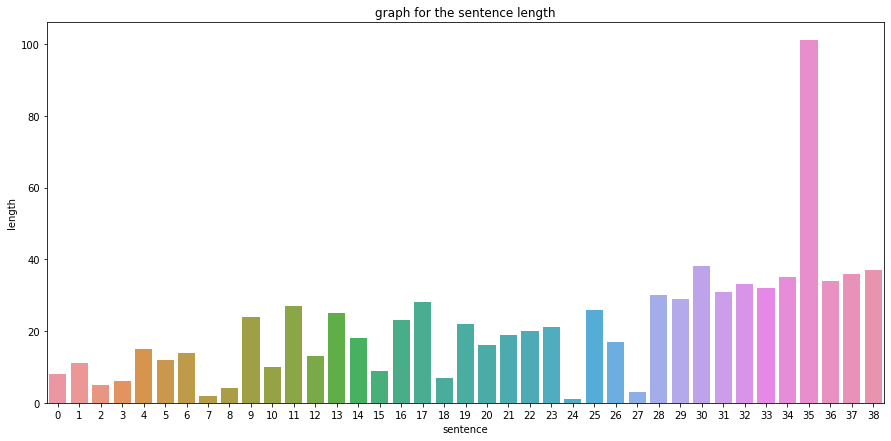

In [12]:
plt.figure(figsize=(15, 7))
unique_lengths = tweet['length'].unique()
sns.barplot(np.arange(len(unique_lengths)), unique_lengths)
plt.title("graph for the sentence length")
plt.xlabel("sentence")
plt.ylabel("length")


Checking for unique words among the snetence

In [13]:
tweet['text'].unique()

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

Getting the array of the word

In [14]:
tweet['length'].unique()

array([  8,  11,   5,   6,  15,  12,  14,   2,   4,  24,  10,  27,  13,
        25,  18,   9,  23,  28,   7,  22,  16,  19,  20,  21,   1,  26,
        17,   3,  30,  29,  38,  31,  33,  32,  35, 101,  34,  36,  37])

Plot of the sentiment

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64



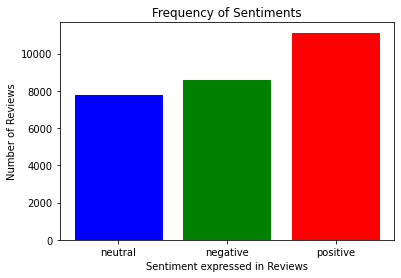

In [15]:
Index = [2, 1, 0]

print(tweet["sentiment"].value_counts())
print()

barlist = plt.bar(Index, tweet["sentiment"].value_counts())

plt.title("Frequency of Sentiments")
plt.xticks(Index, ['positive', 'negative', 'neutral'])
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment expressed in Reviews')

barlist[Index[1]].set_color('green')
barlist[Index[0]].set_color('blue')
barlist[Index[2]].set_color('red')

plt.show()

Application of clean text for bags of word 

In [16]:
tweet['selected_text'] = tweet['text'].apply(clean_text)
tweet_df = tweet.drop(columns=['text', 'length'])
tweet_df

,sentiment,selected_text
0,neutral,id have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my bos is bullying me
3,negative,what interview leave me alone
4,negative,son of why couldnt they put them on the releas...
...,...,...
27476,negative,wish we could come see u on denver husband los...
27477,negative,ive wondered about rake to the client ha made ...
27478,positive,yay good for both of you enjoy the break you p...
27479,positive,but it wa worth it


Visualizing the most frequent words used in the review

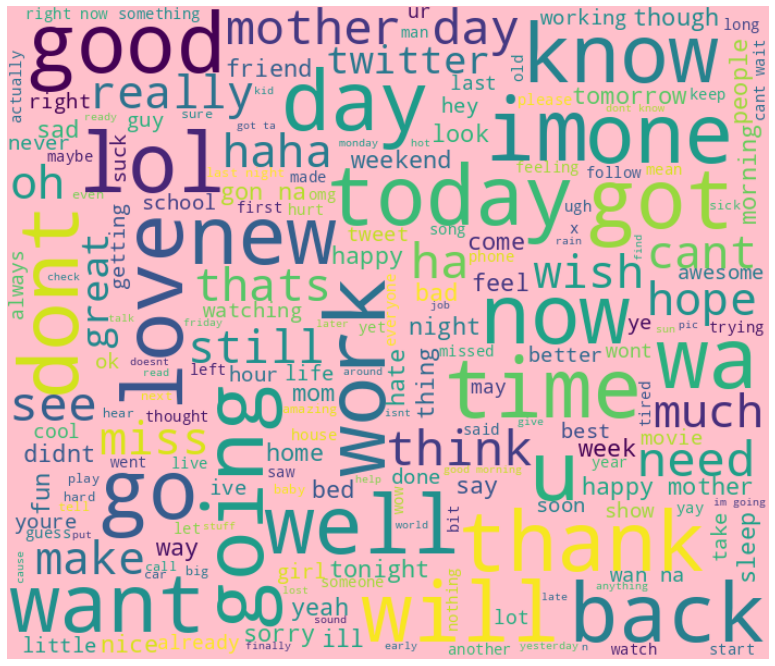

In [17]:
word = " ".join([text for text in tweet['selected_text']])

rainy_word = WordCloud(width = 700, height = 600, random_state = 90, max_font_size = 80, stopwords=STOPWORDS, normalize_plurals=True, collocations=True, relative_scaling=.10, background_color = "pink").generate(word)

plt.figure(figsize = (16, 12))
plt.imshow(rainy_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

Splitting the data set into x and y train and test

In [18]:
x1 = tweet_df.drop(columns=['sentiment'])
y1 = tweet_df['sentiment']

In [19]:
sampling_tweet = SMOTEN(random_state=0)
X, y = sampling_tweet.fit_resample(x1, y1)

In [20]:
X1 = X['selected_text']
X1.shape

(33351,)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = .20, random_state = 90)

In [22]:
print(X_train.shape)
print(y_train.shape)

(26680,)
(26680,)


Creating a pipeline for training dataset using frequency based 

In [23]:
multi_NB = Pipeline([
    ("bag of words", CountVectorizer(stop_words="english")),
    ("classification",  SVC(kernel='linear', tol=1e-05))
])

In [24]:
model = multi_NB.fit(X_train, y_train)

Creating a joblib file

In [25]:
joblib.dump(multi_NB, "models/multinomial_naive_bayes_with_count_vectorizer.joblib")

['models/multinomial_naive_bayes_with_count_vectorizer.joblib']

In [26]:
yhat = model.predict(X_test)

In [27]:
print(confusion_matrix(y_test, yhat))

[[1663  487  103]
 [ 333 1623  255]
 [  99  370 1738]]


In [33]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

    negative       0.79      0.74      0.76      2253
     neutral       0.65      0.73      0.69      2211
    positive       0.83      0.79      0.81      2207

    accuracy                           0.75      6671
   macro avg       0.76      0.75      0.75      6671
weighted avg       0.76      0.75      0.75      6671



Creating a pipeline for training dataset using frequency based 

In [28]:
multi_NBT = Pipeline([
    ("bag of words", TfidfVectorizer(stop_words="english")),
    ("classification", MultinomialNB())
])

In [29]:
multi_NBT.fit(X_train, y_train)

Pipeline(steps=[('bag of words', TfidfVectorizer(stop_words='english')),
                ('classification', MultinomialNB())])

In [30]:
joblib.dump(multi_NBT, "models/multinomial_naive_bayes_with_tfidf_vectorizer.joblib")

['models/multinomial_naive_bayes_with_tfidf_vectorizer.joblib']

In [31]:
y_predict = multi_NBT.predict(X_test)

confusion_matrix(y_test, y_predict)

array([[1270,  870,  113],
       [ 161, 1647,  403],
       [  40,  672, 1495]])

In [32]:
print(classification_report(y_test, X_predict))

NameError: name 'X_predict' is not defined